In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

## Steps
1. Join the kaggle contest - https://www.kaggle.com/competitions/planttraits2024
2. Install kaggle cli - https://github.com/Kaggle/kaggle-api/blob/main/docs/README.md
3. Download the data - `kaggle competitions download -c planttraits2024`
4. Unzip the data
5. Install FGVC repo - `pip install -e .` and `pip install -r requirement.txt` in the desired env
5. Setup data from `data_setup.ipynb`
5. Train the model

In [16]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import omegaconf
import hydra
from lightning import Callback, LightningDataModule, LightningModule, Trainer
from omegaconf import DictConfig
from sklearn.preprocessing import StandardScaler

### DataFrame Analysis

In [3]:
# create this dataframe from data_setup.ipynb
df_all = pd.read_csv('/home/ubuntu/FGVC11/data/PlantTrait/df_processed.csv')
cfg = omegaconf.OmegaConf.load("/home/ubuntu/FGVC11/configs/data/plant_traits_data.yaml")
datamodule: LightningDataModule = hydra.utils.instantiate(cfg)
datamodule.setup()

In [5]:
df_all.split.value_counts()

train    43037
test      6545
val       5972
Name: split, dtype: int64

In [6]:
#all columns must be identical to be consider the same species
label_col = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']
aux_col = list(
            map(lambda x: x.replace("mean", "sd"), label_col)
        )
metadata_col = list(set(df_all.columns) - set(label_col) - set(aux_col) - set(["id", "path", "split", "species"]))
len(label_col), len(aux_col), len(metadata_col)

(6, 6, 163)

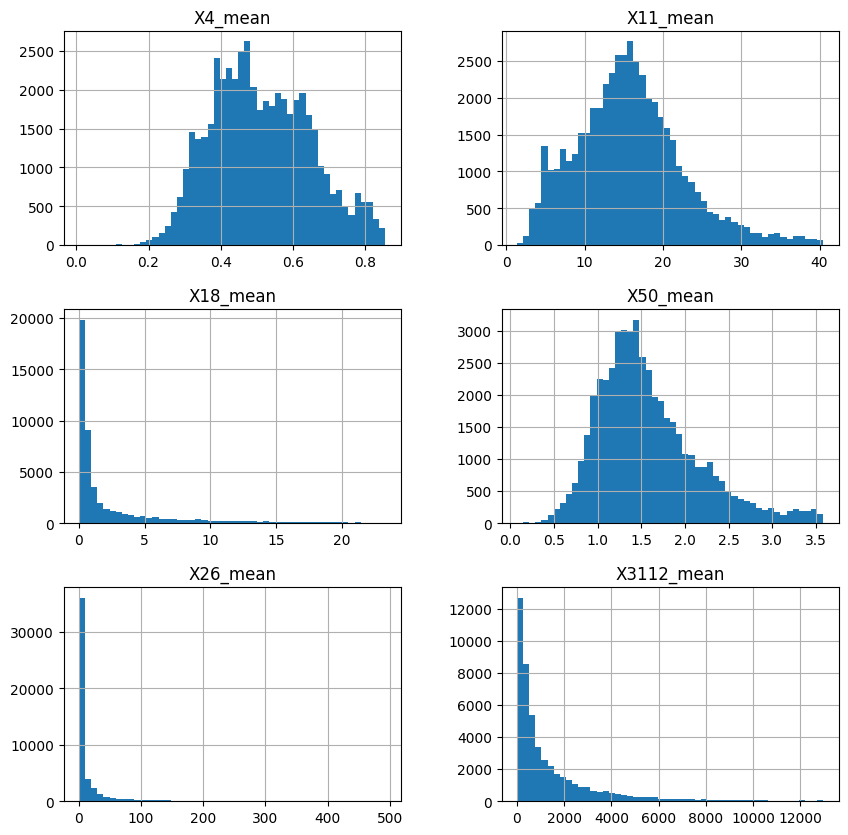

In [10]:
df_all[label_col][df_all.split != "test"].hist(bins=50, figsize=(10, 10))
plt.show()

### Adding CLIP feats

In [ ]:
# import torch
# import clip
# from PIL import Image
# from tqdm import tqdm
# import torchvision.transforms as transforms

# device = "cuda" if torch.cuda.is_available() else "cpu"
# # model, preprocess = clip.load("ViT-B/32", device=device)
# model = torch.hub.load(
#             "facebookresearch/dinov2", "dinov2_vits14_reg", pretrained=True
#         )
# model.to(device);

# # Define the transformations
# transform = transforms.Compose([
#     transforms.Resize((490, 490)),  # Resize the image to a fixed size
#     transforms.ToTensor(),  # Convert the image to a tensor
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
# ])

# feats = []
# for _, row in tqdm(df_train.iterrows(), total=len(df_train)):
#     image = transform(Image.open(row["path"])).unsqueeze(0).to(device)
#     with torch.no_grad():
#         image_features = model(image.to(device))
#         feats.append(image_features.view(-1).cpu().numpy())
#     # break

# feats = np.array(feats)
# # np.save("feats.npy", feats)  

In [ ]:
# np.save("feats_processed.npy", feats)  

In [8]:
feats = np.load("feats_processed.npy")
feats.shape

(55554, 384)

In [12]:
feat_df = pd.DataFrame(feats)

### Run XGBoost

In [13]:
# create the training data
X = df_all[metadata_col][df_all.split != "test"].reset_index(drop=True)
X.shape

(49009, 163)

In [14]:
# add clip feaures and save the final test data
x_final = df_all[metadata_col][df_all.split == "test"].reset_index(drop=True).values
x_final = np.concatenate([x_final, feat_df[df_all.split == "test"].values], axis=1)

dx_final = xgb.DMatrix(x_final, enable_categorical=False)
# Create a DataFrame with the corresponding IDs
submission_df = pd.DataFrame({
    'id': df_all["id"][df_all.split == "test"].values,
})
x_final.shape

(6545, 547)

In [15]:
# load LabelEncoder for trasnforming label to log + standardization 
from fgvc.models.plant_traits_model import LabelEncoder
le = LabelEncoder()

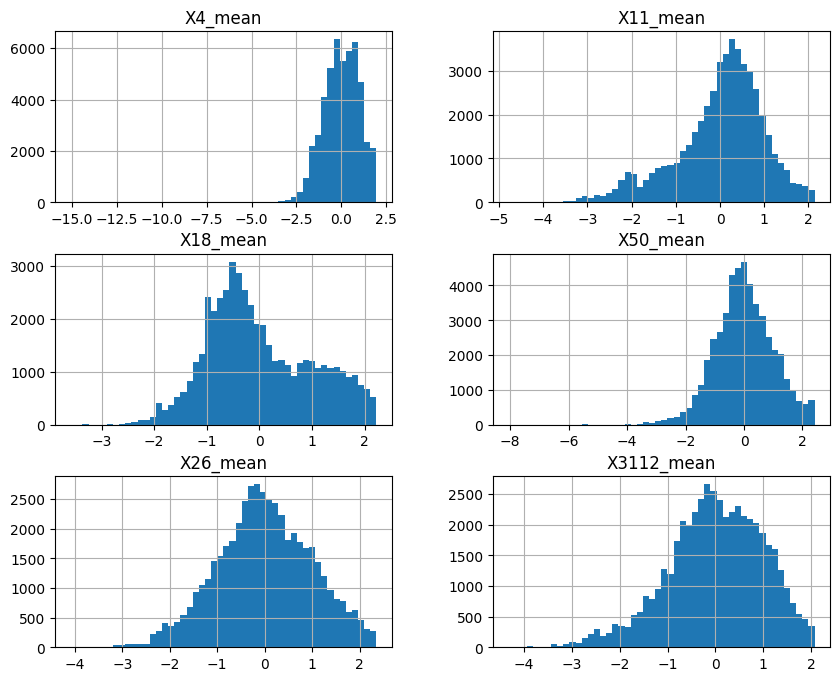

In [17]:
# trasnform labels using label encoder
Y = le.transform(torch.tensor(df_all[label_col][df_all.split != "test"].values)).numpy()
Y = pd.DataFrame(Y, columns=label_col)
Y.hist(bins=50, figsize=(10, 8))
plt.show()

### Train model for all the traits simultaneously

In [18]:
# Split the data
X_train  = X[df_all.split == "train"].values
X_val = X[df_all.split == "val"].values
y_train = Y[df_all.split == "train"].values
y_val = Y[df_all.split == "val"].values

# concatenate clip features
X_train = np.concatenate([X_train, feat_df[df_all.split == "train"].values], axis=1)
X_val = np.concatenate([X_val, feat_df[df_all.split == "val"].values], axis=1)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=False)
dval_reg = xgb.DMatrix(X_val, y_val, enable_categorical=False)

# set hyperparams
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist", "max_depth":2}
n = 1000

evals = [(dval_reg, "validation")]

model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=evals,
    verbose_eval=20,
    # Activate early stopping
    early_stopping_rounds=10
    )

print("*"*100)
# get the encoded prediction
y_train_pred = model.predict(dtrain_reg)
# decode raw predicted traits
y_train_pred = le.inverse_transform(torch.Tensor(y_train_pred)).numpy()
# get the raw labels
y_train = le.inverse_transform(torch.Tensor(y_train)).numpy()
# evaluate
print(f"R2 train: {r2_score(y_train, y_train_pred)}")

# get the encoded prediction
y_val_pred = model.predict(dval_reg)
# decode raw predicted traits
y_train_pred = le.inverse_transform(torch.Tensor(y_train_pred)).numpy()
# get the raw labels
y_train = le.inverse_transform(torch.Tensor(y_train)).numpy()
# evaluate
print(f"R2 val : {r2_score(y_val, y_val_pred)}")

sub_cols = [i.replace("_mean", "") for i in label_col]
# get the encoded prediction
y_final = model.predict(dx_final)
# decode raw predicted traits
y_final = le.inverse_transform(torch.Tensor(y_final)).numpy()
submission_df[sub_cols] = y_final
    
# compare with a good submission from kaggle to sanity check
sub = pd.read_csv('submission_good.csv')
print("R2 with good", r2_score(sub[sub.columns[1:]], submission_df[sub.columns[1:]]))
print("*"*100)


/tmp/ipykernel_3083/1873043181.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train  = X[df_all.split == "train"].values
/tmp/ipykernel_3083/1873043181.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_val = X[df_all.split == "val"].values
/tmp/ipykernel_3083/1873043181.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y_train = Y[df_all.split == "train"].values
/tmp/ipykernel_3083/1873043181.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y_val = Y[df_all.split == "val"].values


(43037, 547) (5972, 547) (43037, 6) (5972, 6)


/home/ubuntu/miniconda3/envs/transformers/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:22:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:0.96463
[20]	validation-rmse:0.81388
[40]	validation-rmse:0.79341
[60]	validation-rmse:0.78321
[80]	validation-rmse:0.77660
[100]	validation-rmse:0.77202
[120]	validation-rmse:0.76779
[140]	validation-rmse:0.76432
[160]	validation-rmse:0.76134
[180]	validation-rmse:0.75908
[200]	validation-rmse:0.75662
[220]	validation-rmse:0.75475
[240]	validation-rmse:0.75289
[260]	validation-rmse:0.75121
[280]	validation-rmse:0.74939
[300]	validation-rmse:0.74814
[320]	validation-rmse:0.74666
[340]	validation-rmse:0.74529
[360]	validation-rmse:0.74408
[380]	validation-rmse:0.74287
[400]	validation-rmse:0.74161
[420]	validation-rmse:0.74058
[440]	validation-rmse:0.73963
[460]	validation-rmse:0.73860
[480]	validation-rmse:0.73767
[500]	validation-rmse:0.73722
[520]	validation-rmse:0.73626
[540]	validation-rmse:0.73512
[560]	validation-rmse:0.73438
[580]	validation-rmse:0.73368
[600]	validation-rmse:0.73275
[620]	validation-rmse:0.73220
[640]	validation-rmse:0.73134
[660]	validation

/home/ubuntu/miniconda3/envs/transformers/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:22:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


R2 val : 0.48164767464186636
R2 with good 0.44365275872370313
****************************************************************************************************


In [ ]:
submission_df[sub.columns].to_csv("submission.csv", index=False)

In [ ]:
# !kaggle competitions submit -c planttraits2024 -f submission.csv -m "xgboost metadata merged"

### For each trait separately

In [ ]:
# # Split the data
# X_train  = X[df_all.split == "train"].values
# X_val = X[df_all.split == "val"].values
# y_train = Y[df_all.split == "train"].values
# y_val = Y[df_all.split == "val"].values

# # concatenate clip features
# X_train = np.concatenate([X_train, feat_df[df_all.split == "train"].values], axis=1)
# X_val = np.concatenate([X_val, feat_df[df_all.split == "val"].values], axis=1)
# print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

# for idx, col in enumerate(label_col):
#     # Create regression matrices
#     dtrain_reg = xgb.DMatrix(X_train, y_train[:, idx], enable_categorical=False)
#     dval_reg = xgb.DMatrix(X_val, y_val[:, idx], enable_categorical=False)
    
#     # set hyperparams
#     params = {"objective": "reg:squarederror", "tree_method": "gpu_hist", "max_depth":2}
#     n = 1000

#     evals = [(dval_reg, "validation")]

#     model = xgb.train(
#         params=params,
#         dtrain=dtrain_reg,
#         num_boost_round=n,
#         evals=evals,
#         verbose_eval=10,
#         # Activate early stopping
#         early_stopping_rounds=10
#         )
    
#     print("*"*100)
#     y_train_pred = model.predict(dtrain_reg)
#     y_train_pred = np.exp(SCALER.inverse_transform(y_train_pred.reshape(-1, 1)))
#     y_train = np.exp(SCALER.inverse_transform(y_train.reshape(-1, 1)))
#     print(f"R2 train {col}: {r2_score(y_train, y_train_pred)}")
    
#     y_val_pred = model.predict(dval_reg)
#     y_val_pred = np.exp(SCALER.inverse_transform(y_val_pred.reshape(-1, 1)))
#     y_val = np.exp(SCALER.inverse_transform(y_val.reshape(-1, 1)))
#     print(f"R2 val {col} : {r2_score(y_val, y_val_pred)}")


#     y_final = model.predict(dx_final)
#     y_final = np.exp(SCALER.inverse_transform(y_final.reshape(-1, 1)))
#     submission_df[col.replace("_mean", "")] = y_final
#     print("*"*100)    
#     # break
# # compare with a good submission from kaggle to sanity check
# sub = pd.read_csv('submission_good.csv')
# r2_score(sub[sub.columns[1:]], submission_df[sub.columns[1:]])

In [ ]:
# make sure columns are in right order, otherwise you'll get absurd values
# submission_df[sub.columns].to_csv('submission.csv', index=False)